In [1]:
import pandas as pd
from pandas import DataFrame
import os
import sys
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.show()
import glob
import seaborn as sns
from collections import Counter
from scipy import stats
pd.set_option("display.max_rows", 10)

matplotlib.__version__


'3.1.0'

In [2]:
os.chdir('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/metabolic_analysis/')

outdir = "./tbls"
figdir = "/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_images/metabolic_analysis"

if not os.path.exists(outdir):
    os.mkdir(outdir)
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [3]:
cols=['COG', 'EC_number', 'gene', 'product']
annotations=pd.read_csv('tbls/prokka_annotations.tsv', sep='\t', usecols=cols)
annotations.dropna(subset=['COG'], inplace=True)
annotations.drop_duplicates(inplace=True)

annotations

/mnt/scgc/scgc_nfs/opt/common/anaconda3a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene,EC_number,COG,product
1,pta,2.3.1.8,COG0280,Phosphate acetyltransferase
3,argO,NaN,COG1279,Arginine exporter protein ArgO
4,ousW,NaN,COG4176,Glycine betaine/choline transport system perme...
5,proV,NaN,COG4175,Glycine betaine/proline betaine transport syst...
6,ousX,NaN,COG2113,Glycine betaine-binding periplasmic protein OusX
...,...,...,...,...
7449559,macB_38,3.6.3.-,COG0577,Macrolide export ATP-binding/permease protein ...
7458752,NaN,NaN,COG3474,Cytochrome c2 iso-1
7459579,pdxT_1,4.3.3.6,COG0311,Pyridoxal 5'-phosphate synthase subunit PdxT
7459603,pdxT_2,4.3.3.6,COG0311,Pyridoxal 5'-phosphate synthase subunit PdxT


In [4]:
transporter=pd.read_csv('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/metabolic_analysis/COG_tables/cog_transporter_table.tsv',
                       sep='\t')
trans_cog=transporter['COG'].to_list()

repair=pd.read_csv('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/metabolic_analysis/COG_tables/cog_photolyase_table.tsv',
                       sep='\t')
repair_cog=repair['COG'].to_list()
repair_cog
len(trans_cog)

81

In [5]:
cols=['COG', 'EC_number', 'gene', 'product']
trans_df=pd.DataFrame(columns=cols)
for i in trans_cog:
    tdf=annotations[annotations['COG']==i]
    trans_df=pd.concat([trans_df, tdf])

trans_df['system']='Transporter'

repair_df=pd.DataFrame(columns=cols)
for i in repair_cog:
    tdf=annotations[annotations['COG']==i]
    repair_df=pd.concat([repair_df, tdf])
repair_df['system']='Photolyase'

repair_df.nunique()

COG_df=pd.concat([trans_df, repair_df], ignore_index=True)

COG_df.drop(columns=['EC_number', 'product'], inplace=True)
COG_df

/mnt/scgc/scgc_nfs/opt/common/anaconda3a/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """
/mnt/scgc/scgc_nfs/opt/common/anaconda3a/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


,COG,gene,system
0,COG0370,feoB,Transporter
1,COG0370,feoB_1,Transporter
2,COG0370,feoB_2,Transporter
3,COG0370,feoB_3,Transporter
4,COG0385,panS,Transporter
...,...,...,...
380,COG1533,splB,Photolyase
381,COG3046,phrB,Photolyase
382,COG3046,phrB_1,Photolyase
383,COG3046,phrB_2,Photolyase


In [6]:
infiles=glob.glob('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/GORG_recruitment/summaries/All*_GoM_RNA_seq_bbmerge_reads_annotated_read_count_by_genus_and_prokka_annotations.csv')
final_df=pd.DataFrame()
for file in infiles:
    df=pd.read_csv(file)
    base=os.path.basename(file)
    base=base[4:10]
    print(base)
    df=df.merge(COG_df, left_on='prokka_gene', right_on='gene', how='right')
    count_df=df.groupby(['genus', 'system'], as_index= False)['exclusive'].sum()
    count_df=count_df.rename(columns={'exclusive':'Number_of_reads'})
    count_df['sample']=base
    final_df=pd.concat([final_df, count_df])
final_df.to_csv(os.path.join(outdir, "Transporter_and photolyase_reads.csv"))
final_df

171102
181030
190402
190709


,genus,system,Number_of_reads,sample
0,AAA164-E04,Photolyase,0.0,171102
1,AAA164-E04,Transporter,5.0,171102
2,AAA536-G10,Photolyase,20.0,171102
3,AAA536-G10,Transporter,92.0,171102
4,AG-337-I02,Transporter,4.0,171102
...,...,...,...,...
214,Vibrio,Transporter,15.0,190709
215,Vicingaceae,Photolyase,0.0,190709
216,Vicingaceae,Transporter,6.0,190709
217,Winogradskyella,Transporter,2.0,190709


In [7]:
cols=['genus','prokka_function', 'prokka_gene', 'ec_number', 'exclusive','shared','transcripts_per_ml','cells_per_ml','transcripts_per_cell']
final_df=pd.DataFrame()


infiles=glob.glob('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/GORG_recruitment/RNA_summaries/All_*_GoM_RNA_seq_bbmerge_reads_annotated_reads_by_gen_and_prokka_annotation_transcripts_per_cell.csv')
for file in infiles:
    df=pd.read_csv(file, names=cols)
    
    base=os.path.basename(file)
    base=base[4:10]
    print(base)
    df=df.merge(COG_df, left_on='prokka_gene', right_on='gene', how='inner')
    df['transcripts_per_cell']=df['transcripts_per_cell'].astype(float)
    df['sample']=base
    df.drop(columns=['ec_number', 'exclusive','shared','transcripts_per_ml','cells_per_ml', 'gene'], inplace=True)
    count_df=df.groupby(['genus', 'system'], as_index= False)['transcripts_per_cell'].sum()
    count_df['date']=base
    final_df=pd.concat([final_df, count_df])
    
final_df.to_csv(os.path.join(outdir, "Transporter_and photolyase_reads_per_cell.csv"))
final_pivot=pd.pivot_table(final_df, values='transcripts_per_cell', columns='system', index=['genus', 'date'])
final_pivot=final_pivot.rename(columns={'Photolyase':'Photolyase_transcripts_per_cell', 'Transporter':'Transporter_transcripts_per_cell'})
final_pivot.reset_index(inplace=True)

final_pivot['date']=final_pivot['date'].astype(int)+20000000
final_pivot

/mnt/scgc/scgc_nfs/opt/common/anaconda3a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


171102
181030
190402
190709


system,genus,date,Photolyase_transcripts_per_cell,Transporter_transcripts_per_cell
0,AAA164-E04,20171102,0.000000,1.251256
1,AAA164-E04,20181030,NaN,0.281921
2,AAA164-E04,20190402,0.000000,0.000000
3,AAA164-E04,20190709,NaN,0.000000
4,AAA536-G10,20171102,0.241244,1.109721
...,...,...,...,...
609,Winogradskyella,20190402,0.000000,0.058617
610,Winogradskyella,20190709,NaN,0.033410
611,Yoonia,20171102,NaN,0.645866
612,Yoonia,20190402,0.056063,0.200225


In [10]:
cols=['proteorhodopsin_transcripts_per_cell', 'Weighted_avg_O2_consumed_per_cell', 'genus', 'date']
transcripts=pd.read_csv('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_images/rRNA/rRNA_O2_transcripts_stats_all_genera.csv', 
                 usecols=cols)
transcripts=transcripts.merge(final_pivot, on=['genus', 'date'], how='inner')
transcripts

,genus,date,Weighted_avg_O2_consumed_per_cell,proteorhodopsin_transcripts_per_cell,Photolyase_transcripts_per_cell,Transporter_transcripts_per_cell
0,AAA164-E04,20171102,0.002330,NaN,0.000000,1.251256
1,AAA164-E04,20181030,0.002050,NaN,NaN,0.281921
2,AAA164-E04,20190402,0.002101,NaN,0.000000,0.000000
3,AAA164-E04,20190709,0.001999,NaN,NaN,0.000000
4,AAA536-G10,20171102,0.002330,1.375089,0.241244,1.109721
...,...,...,...,...,...,...
559,Winogradskyella,20190402,0.002101,0.205159,0.000000,0.058617
560,Winogradskyella,20190709,0.001999,0.083524,NaN,0.033410
561,Yoonia,20171102,0.002330,NaN,NaN,0.645866
562,Yoonia,20190402,0.002101,NaN,0.056063,0.200225


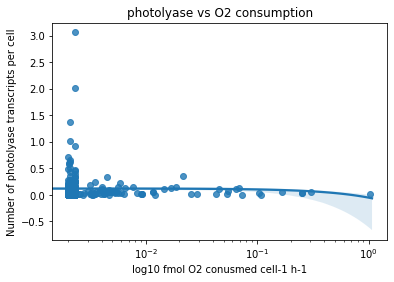

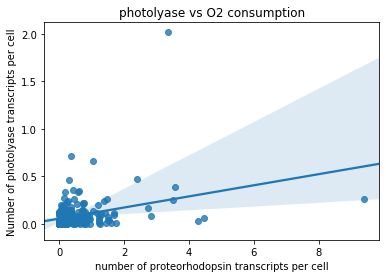

In [22]:

ax=sns.regplot(data=transcripts, x='Weighted_avg_O2_consumed_per_cell', y='Photolyase_transcripts_per_cell')
# create axis labels 
ax.set(xlabel = 'log10 fmol O2 conusmed cell-1 h-1',
       ylabel = 'Number of photolyase transcripts per cell',
       title = 'photolyase vs O2 consumption', 
       xscale = 'log')

plt.show()
plt.savefig(os.path.join(figdir,"O2_consumption_vs_photolyase_transcripts_per_cell.pdf"))


ax=sns.regplot(data=transcripts, x='proteorhodopsin_transcripts_per_cell', y='Photolyase_transcripts_per_cell')
ax.set(xlabel = 'number of proteorhodopsin transcripts per cell',
       ylabel = 'Number of photolyase transcripts per cell',
       title = 'photolyase vs O2 consumption')
plt.savefig(os.path.join(figdir,"proteorhodopsin_vs_photolyase_transcripts_per_cell.pdf"))

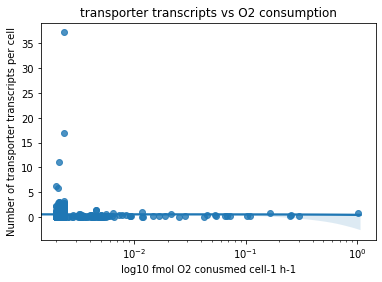

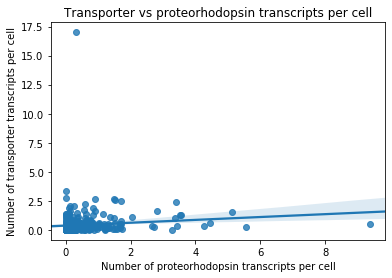

<Figure size 432x288 with 0 Axes>

In [23]:
ax=sns.regplot(data=transcripts, x='Weighted_avg_O2_consumed_per_cell', y='Transporter_transcripts_per_cell')
ax.set(xlabel = 'log10 fmol O2 conusmed cell-1 h-1',
       ylabel = 'Number of transporter transcripts per cell',
       title = 'transporter transcripts vs O2 consumption', 
       xscale = 'log')
plt.show()
plt.savefig(os.path.join(figdir,"O2_consumption_vs_transporter_transcripts_per_cell.pdf"))

ax=sns.regplot(data=transcripts, x='proteorhodopsin_transcripts_per_cell', y='Transporter_transcripts_per_cell')
ax.set(xlabel = 'Number of proteorhodopsin transcripts per cell',
       ylabel = 'Number of transporter transcripts per cell',
       title = 'Transporter vs proteorhodopsin transcripts per cell')
plt.show()
plt.savefig(os.path.join(figdir,"proteorhodopsin_vs_transporter_transcripts_per_cell.pdf"))